# Project Description


Detecting Pediatric Acute Lymphoblastic Leukemia using Computer Vision

https://omdena.com/chapter-challenges/detecting-pediatric-acute-lymphoblastic-leukemia-using-computer-vision/

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Required Packages

In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.2 MB/s eta 0:00:00


# Imports

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
  

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import sklearn.metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

import optuna




# Load Data - Batch 4


In [4]:
!unzip '/content/drive/MyDrive/omdena_liverpool_all/C-NMC_Leukemia/training_test_pickle/batch_4.zip'

Archive:  /content/drive/MyDrive/omdena_liverpool_all/C-NMC_Leukemia/training_test_pickle/batch_4.zip
 extracting: batch_4/class_labels.txt  
  inflating: batch_4/test_data.pickle  
  inflating: batch_4/train_data.pickle  


In [5]:
df_train = pd.read_pickle('./batch_4/train_data.pickle')
df_test = pd.read_pickle('./batch_4/test_data.pickle')

In [6]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.185833,0.0,0.00000,0.000000,0.0,0.0,0.0,0.231458,0.0,0.0,...,0.545079,0.170755,0.0,0.096298,0.174819,0.0,0.0,0.361853,0.0,0
1,0.123157,0.0,0.56544,0.350086,0.0,0.0,0.0,0.228849,0.0,0.0,...,0.663390,0.115025,0.0,0.099379,0.516193,0.0,0.0,0.239392,0.0,1
2,0.197977,0.0,0.00000,0.000000,0.0,0.0,0.0,0.155163,0.0,0.0,...,0.663023,0.021846,0.0,0.000000,0.173690,0.0,0.0,0.270634,0.0,1
3,0.580151,0.0,0.00000,0.000000,0.0,0.0,0.0,0.298566,0.0,0.0,...,0.470815,0.000000,0.0,0.000000,0.118325,0.0,0.0,0.000000,0.0,0
4,0.066450,0.0,0.00000,0.000000,0.0,0.0,0.0,0.145156,0.0,0.0,...,0.645798,0.015262,0.0,0.027536,0.275665,0.0,0.0,0.000000,0.0,0


In [7]:
df_train.shape

(11917, 4609)

In [8]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.141500,0.0,0.000000,0.000000,0.0,0.0,0.0,0.151137,0.0,0.0,...,0.885778,0.066009,0.0,0.169458,0.570154,0.0,0.0,0.090579,0.0,0
1,0.047403,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.649062,0.260996,0.0,0.049776,0.494771,0.0,0.0,0.480568,0.0,0
2,0.000000,0.0,0.000000,0.023559,0.0,0.0,0.0,0.060329,0.0,0.0,...,0.725523,0.166289,0.0,0.131945,0.299330,0.0,0.0,0.000000,0.0,0
3,0.002286,0.0,0.655825,0.259398,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.626934,0.244303,0.0,0.100791,0.448022,0.0,0.0,0.295682,0.0,0
4,0.279953,0.0,0.000000,0.000000,0.0,0.0,0.0,0.168589,0.0,0.0,...,0.489483,0.166786,0.0,0.000000,0.212874,0.0,0.0,0.000000,0.0,0


In [9]:
df_test.shape

(1794, 4609)

# Create X and y Data to Feed ML Models

In [10]:
X_train = np.array(df_train.iloc[:,:-1].copy())
y_train = np.array(df_train['label'].copy())

In [11]:
(X_train.shape, y_train.shape)

((11917, 4608), (11917,))

In [12]:
X_test = np.array(df_test.iloc[:,:-1].copy())
y_test = np.array(df_test['label'].copy())

In [13]:
(X_test.shape, y_test.shape)

((1794, 4608), (1794,))

# Classification using Stacking Ensembles

REFs: 
 
https://www.youtube.com/watch?v=0BGLfYY26zQ

https://github.com/dataprofessor/python/blob/main/Stacking_Classifier.ipynb

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score

## Knn Classifier

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(3) # Define classifier
knn.fit(X_train, y_train) # Train model

# Make predictions
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Training set performance
knn_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
knn_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
knn_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
knn_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
knn_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
knn_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % knn_train_accuracy)
print('- MCC: %s' % knn_train_mcc)
print('- F1 score: %s' % knn_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % knn_test_accuracy)
print('- MCC: %s' % knn_test_mcc)
print('- F1 score: %s' % knn_test_f1)

Model performance for Training set
- Accuracy: 0.8936812956280943
- MCC: 0.7872602367090045
- F1 score: 0.8936846826872915
----------------------------------
Model performance for Test set
- Accuracy: 0.7324414715719063
- MCC: 0.3193938476807663
- F1 score: 0.7543916228698837


## Decision Tree Classifier

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5) # Define classifier
dt.fit(X_train, y_train) # Train model

# Make predictions
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# Training set performance
dt_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
dt_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
dt_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
dt_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
dt_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
dt_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % dt_train_accuracy)
print('- MCC: %s' % dt_train_mcc)
print('- F1 score: %s' % dt_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % dt_test_accuracy)
print('- MCC: %s' % dt_test_mcc)
print('- F1 score: %s' % dt_test_f1)

Model performance for Training set
- Accuracy: 0.7915582780901234
- MCC: 0.5832830448041814
- F1 score: 0.7915876694061622
----------------------------------
Model performance for Test set
- Accuracy: 0.7212931995540691
- MCC: 0.2935654956668235
- F1 score: 0.7445156693780305


## Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10) # Define classifier
rf.fit(X_train, y_train) # Train model

# Make predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Training set performance
rf_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
rf_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
rf_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
rf_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
rf_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
rf_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % rf_train_accuracy)
print('- MCC: %s' % rf_train_mcc)
print('- F1 score: %s' % rf_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % rf_test_accuracy)
print('- MCC: %s' % rf_test_mcc)
print('- F1 score: %s' % rf_test_f1)
     

Model performance for Training set
- Accuracy: 0.9939582109591341
- MCC: 0.9879152853983374
- F1 score: 0.9939579253061464
----------------------------------
Model performance for Test set
- Accuracy: 0.7335562987736901
- MCC: 0.34157388253047133
- F1 score: 0.7567224360702622


## NN Classifier

In [18]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=1, max_iter=1000)
mlp.fit(X_train, y_train)

# Make predictions
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

# Training set performance
mlp_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
mlp_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
mlp_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
mlp_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
mlp_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
mlp_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % mlp_train_accuracy)
print('- MCC: %s' % mlp_train_mcc)
print('- F1 score: %s' % mlp_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % mlp_test_accuracy)
print('- MCC: %s' % mlp_test_mcc)
print('- F1 score: %s' % mlp_test_f1)

Model performance for Training set
- Accuracy: 0.880590752706218
- MCC: 0.7658783125169396
- F1 score: 0.880409246241221
----------------------------------
Model performance for Test set
- Accuracy: 0.8450390189520625
- MCC: 0.5082605000897346
- F1 score: 0.8470435962074758


## Stacking Models

In [19]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimator_list = [
    ('knn',knn),
    ('dt',dt),
    ('rf',rf),
    ('mlp',mlp) ]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

# Train stacked model
stack_model.fit(X_train, y_train)

# Make predictions
y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_test)

# Training set model performance
stack_model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
stack_model_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
stack_model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set model performance
stack_model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
stack_model_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
stack_model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % stack_model_train_accuracy)
print('- MCC: %s' % stack_model_train_mcc)
print('- F1 score: %s' % stack_model_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % stack_model_test_accuracy)
print('- MCC: %s' % stack_model_test_mcc)
print('- F1 score: %s' % stack_model_test_f1)

Model performance for Training set
- Accuracy: 0.9257363430393556
- MCC: 0.8521009281567695
- F1 score: 0.9256585274476621
----------------------------------
Model performance for Test set
- Accuracy: 0.7837235228539576
- MCC: 0.4636022074884705
- F1 score: 0.8016525527216903


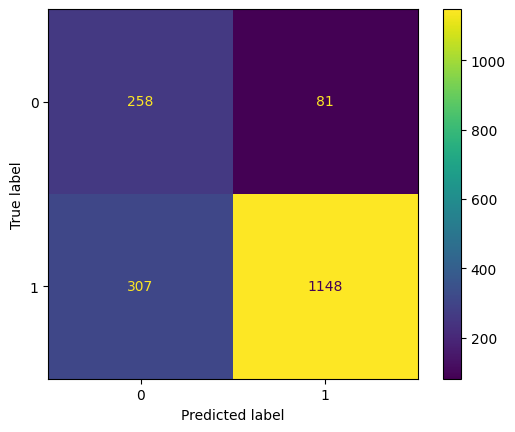

In [20]:
y_pred = y_test_pred 
cm= confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.76      0.57       339
           1       0.93      0.79      0.86      1455

    accuracy                           0.78      1794
   macro avg       0.70      0.78      0.71      1794
weighted avg       0.84      0.78      0.80      1794



# Results Comparison

## Train Results

In [22]:
acc_train_list = {'knn':knn_train_accuracy,
'dt': dt_train_accuracy,
'rf': rf_train_accuracy,
'mlp': mlp_train_accuracy,
'stack': stack_model_train_accuracy}

mcc_train_list = {'knn':knn_train_mcc,
'dt': dt_train_mcc,
'rf': rf_train_mcc,
'mlp': mlp_train_mcc,
'stack': stack_model_train_mcc}

f1_train_list = {'knn':knn_train_f1,
'dt': dt_train_f1,
'rf': rf_train_f1,
'mlp': mlp_train_f1,
'stack': stack_model_train_f1}
     

In [23]:
mcc_train_list

{'knn': 0.7872602367090045,
 'dt': 0.5832830448041814,
 'rf': 0.9879152853983374,
 'mlp': 0.7658783125169396,
 'stack': 0.8521009281567695}

In [24]:
acc_df = pd.DataFrame.from_dict(acc_train_list, orient='index', columns=['Accuracy'])
mcc_df = pd.DataFrame.from_dict(mcc_train_list, orient='index', columns=['MCC'])
f1_df = pd.DataFrame.from_dict(f1_train_list, orient='index', columns=['F1'])
df = pd.concat([acc_df, mcc_df, f1_df], axis=1)
df

,Accuracy,MCC,F1
knn,0.893681,0.787260,0.893685
dt,0.791558,0.583283,0.791588
rf,0.993958,0.987915,0.993958
mlp,0.880591,0.765878,0.880409
stack,0.925736,0.852101,0.925659


## Test results

In [25]:
acc_test_list = {'knn':knn_test_accuracy,
'dt': dt_test_accuracy,
'rf': rf_test_accuracy,
'mlp': mlp_test_accuracy,
'stack': stack_model_test_accuracy}

mcc_test_list = {'knn':knn_test_mcc,
'dt': dt_test_mcc,
'rf': rf_test_mcc,
'mlp': mlp_test_mcc,
'stack': stack_model_test_mcc}

f1_test_list = {'knn':knn_test_f1,
'dt': dt_test_f1,
'rf': rf_test_f1,
'mlp': mlp_test_f1,
'stack': stack_model_test_f1}

In [26]:
acc_df = pd.DataFrame.from_dict(acc_test_list, orient='index', columns=['Accuracy'])
mcc_df = pd.DataFrame.from_dict(mcc_test_list, orient='index', columns=['MCC'])
f1_df = pd.DataFrame.from_dict(f1_test_list, orient='index', columns=['F1'])
df = pd.concat([acc_df, mcc_df, f1_df], axis=1)
df

,Accuracy,MCC,F1
knn,0.732441,0.319394,0.754392
dt,0.721293,0.293565,0.744516
rf,0.733556,0.341574,0.756722
mlp,0.845039,0.508261,0.847044
stack,0.783724,0.463602,0.801653


# Voting Ensemble Classifiers

In [27]:
# Define estimators
from sklearn.ensemble import VotingClassifier

estimator_list = [
    ('knn',knn),
    ('dt',dt),
    ('rf',rf),
    ('mlp',mlp) ]

# Build voting model
stack_model = VotingClassifier(
    estimators=estimator_list, voting='hard'
)

# Train stacked model
stack_model.fit(X_train, y_train)

# Make predictions
y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_test)

# Training set model performance
stack_model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
stack_model_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
stack_model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set model performance
stack_model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
stack_model_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
stack_model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % stack_model_train_accuracy)
print('- MCC: %s' % stack_model_train_mcc)
print('- F1 score: %s' % stack_model_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % stack_model_test_accuracy)
print('- MCC: %s' % stack_model_test_mcc)
print('- F1 score: %s' % stack_model_test_f1)

Model performance for Training set
- Accuracy: 0.9473860871024586
- MCC: 0.8948217660623433
- F1 score: 0.9473698667267705
----------------------------------
Model performance for Test set
- Accuracy: 0.7809364548494984
- MCC: 0.4493214655915138
- F1 score: 0.798667329049979


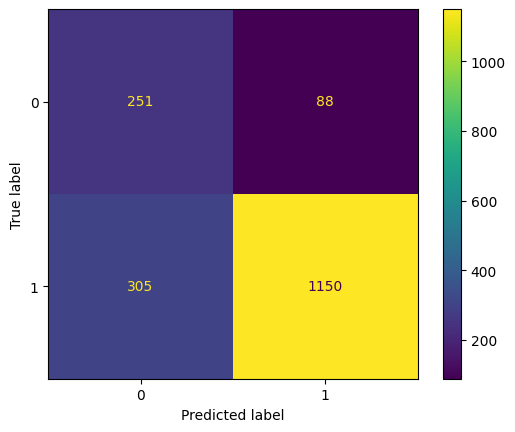

In [28]:
y_pred = y_test_pred 
cm= confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.74      0.56       339
           1       0.93      0.79      0.85      1455

    accuracy                           0.78      1794
   macro avg       0.69      0.77      0.71      1794
weighted avg       0.84      0.78      0.80      1794



# Results Comparison

## Train results

In [32]:
acc_train_list = {'knn':knn_train_accuracy,
'dt': dt_train_accuracy,
'rf': rf_train_accuracy,
'mlp': mlp_train_accuracy,
'voting': stack_model_train_accuracy}

mcc_train_list = {'knn':knn_train_mcc,
'dt': dt_train_mcc,
'rf': rf_train_mcc,
'mlp': mlp_train_mcc,
'voting': stack_model_train_mcc}

f1_train_list = {'knn':knn_train_f1,
'dt': dt_train_f1,
'rf': rf_train_f1,
'mlp': mlp_train_f1,
'voting': stack_model_train_f1}

In [33]:
acc_df = pd.DataFrame.from_dict(acc_train_list, orient='index', columns=['Accuracy'])
mcc_df = pd.DataFrame.from_dict(mcc_train_list, orient='index', columns=['MCC'])
f1_df = pd.DataFrame.from_dict(f1_train_list, orient='index', columns=['F1'])
df = pd.concat([acc_df, mcc_df, f1_df], axis=1)
df

,Accuracy,MCC,F1
knn,0.893681,0.787260,0.893685
dt,0.791558,0.583283,0.791588
rf,0.993958,0.987915,0.993958
mlp,0.880591,0.765878,0.880409
voting,0.947386,0.894822,0.947370


## Test results

In [34]:
acc_test_list = {'knn':knn_test_accuracy,
'dt': dt_test_accuracy,
'rf': rf_test_accuracy,
'mlp': mlp_test_accuracy,
'voting': stack_model_test_accuracy}

mcc_test_list = {'knn':knn_test_mcc,
'dt': dt_test_mcc,
'rf': rf_test_mcc,
'mlp': mlp_test_mcc,
'voting': stack_model_test_mcc}

f1_test_list = {'knn':knn_test_f1,
'dt': dt_test_f1,
'rf': rf_test_f1,
'mlp': mlp_test_f1,
'voting': stack_model_test_f1}

In [35]:
acc_df = pd.DataFrame.from_dict(acc_test_list, orient='index', columns=['Accuracy'])
mcc_df = pd.DataFrame.from_dict(mcc_test_list, orient='index', columns=['MCC'])
f1_df = pd.DataFrame.from_dict(f1_test_list, orient='index', columns=['F1'])
df = pd.concat([acc_df, mcc_df, f1_df], axis=1)
df

,Accuracy,MCC,F1
knn,0.732441,0.319394,0.754392
dt,0.721293,0.293565,0.744516
rf,0.733556,0.341574,0.756722
mlp,0.845039,0.508261,0.847044
voting,0.780936,0.449321,0.798667
